In [1]:
import random
import numpy as np
import torch

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmasrk = False

## create Datasets

### create dataloader

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
import os

### data transform

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
datasets_folder='./plant_diseases/'

images_datasets = {x:datasets.ImageFolder(os.path.join(datasets_folder,x),data_transforms[x]) for x in ['train','valid']}

dataloaders = {x: DataLoader(images_datasets[x],batch_size=64,shuffle=True,num_workers=5) for x in ['train','valid']}

dataset_sizes = {x: len(images_datasets[x]) for x in ['train', 'valid']}

print('Using {} images for training and {} images for validation'.format(dataset_sizes['train'],dataset_sizes['valid']))

Using 18292 images for training and 6097 images for validation


### save indices file

In [6]:
import json

In [7]:
class_names = images_datasets['train'].class_to_idx

In [8]:
cla_dict = dict((val, key) for key, val in class_names.items())
json_str = json.dumps(cla_dict, indent=4)
json_floder = os.path.join(datasets_folder,'output')
if not os.path.exists(json_floder):
    os.mkdir(json_floder)
jsonname = os.path.join(json_floder,'class_indices_test.json')
with open(jsonname, 'w') as json_file:
    json_file.write(json_str)

## create models

In [9]:
from torchvision import models

In [10]:
import torch.nn as nn

In [11]:
efficientnet=models.efficientnet_b0(pretrained=True)

In [12]:
num_cls = len(class_names.values())

In [13]:
efficientnet.classifier[1]=nn.Linear(in_features=1280,out_features=num_cls)

In [14]:
efficientnet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=15, bias=True)
)

## loss function and optimizer

In [15]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnet.parameters(),lr=0.001,momentum=0.9)

In [17]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [18]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
model=efficientnet

## train & eval(valid)

In [20]:
import time

In [21]:
from collections import defaultdict

In [22]:
device  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('using {} device'.format(device))

using cuda:0 device


In [23]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [24]:
epoches = 50

In [25]:
acc_loss_dict = defaultdict(list)

start = time.time()

best_acc = 0.0

for epoch in range(epoches):
    
    print('Epoch {}/{}'.format(epoch+1, epoches))
    
    model.train()
    
    train_loss = 0.0
    train_accuracy = 0
    for inputs, labels in dataloaders['train']:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs=model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_accuracy += torch.sum(preds == labels.data)
        
    scheduler.step()
        
    train_epoch_loss = train_loss / dataset_sizes['train']
    train_epoch_acc = train_accuracy.double() / dataset_sizes['train']
    
    acc_loss_dict['train_acc'].append(train_epoch_acc)
    acc_loss_dict['train_loss'].append(train_epoch_loss)
    
    print('train Loss: {:.4f} Acc: {:.4f}'.format(train_epoch_loss, train_epoch_acc))
    
    model.eval()
    
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for valin,valel in dataloaders['valid']:
            valin = valin.to(device)
            valel = valel.to(device)
            valout=model(valin)
            valloss = criterion(valout, valel)
            _, valpred = torch.max(valout, 1)
            val_loss += valloss.item() * valin.size(0)
            val_accuracy += torch.sum(valpred == valel.data)
        val_epoch_loss = val_loss / dataset_sizes['valid']
        val_epoch_acc = val_accuracy.double() / dataset_sizes['valid']
    
    acc_loss_dict['valid_acc'].append(val_epoch_acc)
    acc_loss_dict['valid_loss'].append(val_epoch_loss)
    
    print('valid Loss: {:.4f} Acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc))
    
    if val_epoch_acc > best_acc:
        patience = 0
        best_acc = val_epoch_acc
        outweights = os.path.join(datasets_folder,'output',model._get_name()+'_weight.pt')
        torch.save(model.state_dict(), outweights)
    else:
        patience += 1
        print("Counter {} of 5".format(patience))
        if patience > 4:
            print("Early stopping with best_acc:{:.4f} ".format(best_acc.item()))
            break
end = time.time()
time_elapsed = end - start
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

Epoch 1/50
train Loss: 1.5045 Acc: 0.6705
valid Loss: 0.5539 Acc: 0.8940
Epoch 2/50
train Loss: 0.3994 Acc: 0.9100
valid Loss: 0.2165 Acc: 0.9457
Epoch 3/50
train Loss: 0.2091 Acc: 0.9471
valid Loss: 0.1333 Acc: 0.9642
Epoch 4/50
train Loss: 0.1391 Acc: 0.9640
valid Loss: 0.0907 Acc: 0.9752
Epoch 5/50
train Loss: 0.1021 Acc: 0.9733
valid Loss: 0.0717 Acc: 0.9808
Epoch 6/50
train Loss: 0.0825 Acc: 0.9789
valid Loss: 0.0698 Acc: 0.9806
Counter 1 of 5
Epoch 7/50
train Loss: 0.0834 Acc: 0.9782
valid Loss: 0.0666 Acc: 0.9813
Epoch 8/50
train Loss: 0.0801 Acc: 0.9787
valid Loss: 0.0672 Acc: 0.9820
Epoch 9/50
train Loss: 0.0814 Acc: 0.9784
valid Loss: 0.0649 Acc: 0.9821
Epoch 10/50
train Loss: 0.0746 Acc: 0.9814
valid Loss: 0.0638 Acc: 0.9818
Counter 1 of 5
Epoch 11/50
train Loss: 0.0747 Acc: 0.9815
valid Loss: 0.0633 Acc: 0.9831
Epoch 12/50
train Loss: 0.0761 Acc: 0.9802
valid Loss: 0.0645 Acc: 0.9820
Counter 1 of 5
Epoch 13/50
train Loss: 0.0761 Acc: 0.9801
valid Loss: 0.0640 Acc: 0.9818
Co

## model evaluate

### accuracy and loss curve

In [32]:
import matplotlib.pyplot as plt

In [33]:
test_train_acc = acc_loss_dict['train_acc']
test_train_loss = acc_loss_dict['train_loss']
test_val_acc = acc_loss_dict['valid_acc']
test_val_loss = acc_loss_dict['valid_loss']

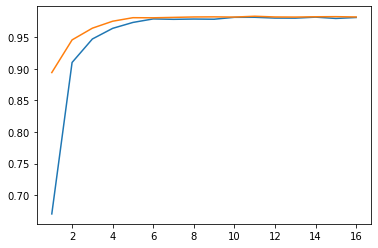

In [36]:
plt.plot(range(1,17),test_train_acc)
plt.plot(range(1,17),test_val_acc)

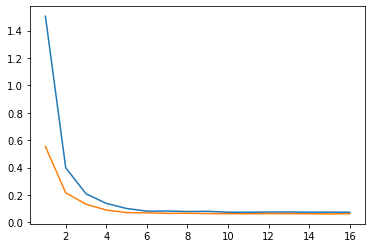

In [37]:
plt.plot(range(1,17),test_train_loss)
plt.plot(range(1,17),test_val_loss)

## predict on test datasets

In [40]:
import glob

In [55]:
from PIL import Image

In [61]:
import pandas as pd

In [38]:
test_floder = './plant_diseases/test/'

In [41]:
test_images = glob.glob(test_floder+'*/*')

In [42]:
len(test_images)

6098

In [43]:
test_images[:10]

['./plant_diseases/test/Tomato_mosaic_virus/d8106a03-3742-4e57-9ea7-d634b56c76cf___PSU_CG 2265_270deg.JPG',
 './plant_diseases/test/Tomato_mosaic_virus/146eaf68-7f61-4717-ac81-2f8bb4533fec___PSU_CG 2406_270deg.JPG',
 './plant_diseases/test/Tomato_mosaic_virus/2e03280e-123a-4231-a73a-652c57338137___PSU_CG 2053_180deg.JPG',
 './plant_diseases/test/Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169_270deg.JPG',
 './plant_diseases/test/Tomato_mosaic_virus/c1ff629a-8390-43a4-88ed-86e462d688a7___PSU_CG 2083_270deg.JPG',
 './plant_diseases/test/Tomato_mosaic_virus/b8972ee2-b576-4fdd-bb69-f8c43b87471b___PSU_CG 2060_180deg.JPG',
 './plant_diseases/test/Tomato_mosaic_virus/7d961b54-7557-4800-ae6a-00b6945f99c0___PSU_CG 2293_270deg.JPG',
 './plant_diseases/test/Tomato_mosaic_virus/6e67c953-5934-439c-8303-e1762793a36a___PSU_CG 2181.JPG',
 './plant_diseases/test/Tomato_mosaic_virus/c9bbf37c-d34f-41b7-9134-e3b81f4e739e___PSU_CG 2145_270deg.JPG',
 './plant_diseases/test/Tomato_mosa

In [47]:
test_labels = [path.split('/')[-2] for path in test_images]

In [49]:
from torch.utils.data import DataLoader

In [50]:
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

testdir = "./plant_diseases/test/"
img_path_list = []
for plant in os.listdir(testdir):
    path = testdir + plant + "/*"
    images = glob.glob(path)
    img_path_list.extend(images)

img_list = []
for img_path in img_path_list:
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = test_transform(img)
    img_list.append(img)
    
json_path = './plant_diseases/output/class_indices_test.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

json_file = open(json_path, "r")
class_indict = json.load(json_file)

In [110]:
model_name = model._get_name()
result = defaultdict(list)
for i in range(0, len(img_list), 100):
    batch_img = torch.stack(img_list[i:i + 100], dim=0)
    with torch.no_grad():
        test_output = model(batch_img.to(device))
        test_pred = torch.softmax(test_output, dim=1)
        probs, classes = torch.max(test_pred, dim=1)
        for idx, (pro, cla,probes) in enumerate(zip(probs, classes,test_pred)):
            result['img'].append(img_path_list[i + idx])
            result['max_prob'].append(pro.cpu().numpy())
            index = cla.cpu().numpy()
            result['cla'].append(class_indict[str(index)])
            result['probs'].append(probes.cpu().numpy())
            print("image: {}  class: {}  prob: {:.3}".format(img_path_list[i + idx],
                                                             class_indict[str(index)],
                                                             pro.cpu().numpy()))
df = pd.DataFrame.from_dict(result)
outname = "./plant_diseases/output/" + model_name + "_predict_test.csv"
df.to_csv(outname)

image: ./plant_diseases/test/Tomato_mosaic_virus/d8106a03-3742-4e57-9ea7-d634b56c76cf___PSU_CG 2265_270deg.JPG  class: Tomato_mosaic_virus  prob: 0.998
image: ./plant_diseases/test/Tomato_mosaic_virus/146eaf68-7f61-4717-ac81-2f8bb4533fec___PSU_CG 2406_270deg.JPG  class: Tomato_mosaic_virus  prob: 0.879
image: ./plant_diseases/test/Tomato_mosaic_virus/2e03280e-123a-4231-a73a-652c57338137___PSU_CG 2053_180deg.JPG  class: Tomato_mosaic_virus  prob: 0.991
image: ./plant_diseases/test/Tomato_mosaic_virus/000ec6ea-9063-4c33-8abe-d58ca8a88878___PSU_CG 2169_270deg.JPG  class: Tomato_mosaic_virus  prob: 0.998
image: ./plant_diseases/test/Tomato_mosaic_virus/c1ff629a-8390-43a4-88ed-86e462d688a7___PSU_CG 2083_270deg.JPG  class: Tomato_mosaic_virus  prob: 0.998
image: ./plant_diseases/test/Tomato_mosaic_virus/b8972ee2-b576-4fdd-bb69-f8c43b87471b___PSU_CG 2060_180deg.JPG  class: Tomato_mosaic_virus  prob: 0.988
image: ./plant_diseases/test/Tomato_mosaic_virus/7d961b54-7557-4800-ae6a-00b6945f99c0___

image: ./plant_diseases/test/Tomato_mosaic_virus/6f341314-6084-4784-a3ba-0a9bdc944366___PSU_CG 2372_270deg.JPG  class: Tomato_mosaic_virus  prob: 0.992
image: ./plant_diseases/test/Tomato_mosaic_virus/c7f8e876-66c2-4014-82a4-47d4556bfb7d___PSU_CG 2418_270deg.JPG  class: Tomato_mosaic_virus  prob: 0.95
image: ./plant_diseases/test/Tomato_mosaic_virus/cc8059de-bae3-4ace-b6a5-f12a07fef342___PSU_CG 2410_180deg.JPG  class: Tomato_mosaic_virus  prob: 0.91
image: ./plant_diseases/test/Tomato_mosaic_virus/72124620-ccfa-40d7-a518-a0257def7afc___PSU_CG 2335_90deg.JPG  class: Tomato_mosaic_virus  prob: 0.998
image: ./plant_diseases/test/Tomato_mosaic_virus/457f4e02-65b3-4e02-ba87-7f20ab44f89e___PSU_CG 2180_270deg.JPG  class: Tomato_mosaic_virus  prob: 0.981
image: ./plant_diseases/test/Tomato_mosaic_virus/b1d9c785-6ef9-4e5b-bb01-f63fb1fce2d2___PSU_CG 2305_270deg.JPG  class: Tomato_mosaic_virus  prob: 0.999
image: ./plant_diseases/test/Tomato_mosaic_virus/9876590b-d8fd-48b0-9b48-c8ed707db6f8___PSU

image: ./plant_diseases/test/Apple_healthy/595381e5-c16b-4348-aaea-00763903646d___RS_HL 6153_flipTB.JPG  class: Apple_healthy  prob: 0.999
image: ./plant_diseases/test/Apple_healthy/77004cfa-f435-49af-8435-7986927228ca___RS_HL 7609.JPG  class: Apple_healthy  prob: 0.99
image: ./plant_diseases/test/Apple_healthy/c1fb257d-b00b-4a71-baad-92a73af09f52___RS_HL 5745_flipTB.JPG  class: Apple_healthy  prob: 0.989
image: ./plant_diseases/test/Apple_healthy/04032305-5ca9-4110-b517-461f13c95f18___RS_HL 7446.JPG  class: Apple_healthy  prob: 0.996
image: ./plant_diseases/test/Apple_healthy/ac9eef55-7ba7-4663-913a-6c68fc5b3376___RS_HL 5696.JPG  class: Apple_healthy  prob: 0.998
image: ./plant_diseases/test/Apple_healthy/c866af3f-3279-42b7-8e3d-f4f1a84f733b___RS_HL 5883_flipTB.JPG  class: Apple_healthy  prob: 0.999
image: ./plant_diseases/test/Apple_healthy/cc804c2c-87af-4c9f-b347-344701081271___RS_HL 7275.JPG  class: Apple_healthy  prob: 0.977
image: ./plant_diseases/test/Apple_healthy/c6d8dca1-8921

image: ./plant_diseases/test/Apple_healthy/1230a95a-5f08-4fd6-b6e9-44c0c7b1fe8c___RS_HL 8092_flipTB.JPG  class: Apple_healthy  prob: 0.917
image: ./plant_diseases/test/Apple_healthy/00a6039c-e425-4f7d-81b1-d6b0e668517e___RS_HL 7669.JPG  class: Apple_healthy  prob: 0.984
image: ./plant_diseases/test/Apple_healthy/b17878ef-2476-4eba-9bdf-0a7950edae2a___RS_HL 7957_flipTB.JPG  class: Apple_healthy  prob: 0.982
image: ./plant_diseases/test/Apple_healthy/38394f24-6b80-4231-b2c4-850325c0718d___RS_HL 7968_flipTB.JPG  class: Apple_healthy  prob: 0.995
image: ./plant_diseases/test/Apple_healthy/4c7d424b-d418-4b72-84a9-2a639eabb5ec___RS_HL 5734.JPG  class: Apple_healthy  prob: 0.999
image: ./plant_diseases/test/Apple_healthy/962f2c1c-b6e2-4428-9ed1-077a92250128___RS_HL 5806_flipTB.JPG  class: Apple_healthy  prob: 0.98
image: ./plant_diseases/test/Apple_healthy/b68238fa-2e01-43b2-bf8c-0e9d38848b02___RS_HL 6289.JPG  class: Apple_healthy  prob: 0.999
image: ./plant_diseases/test/Apple_healthy/70491e

image: ./plant_diseases/test/Apple_healthy/e77cdcd7-1279-4cd1-87db-9d80721311b4___RS_HL 6283.JPG  class: Apple_healthy  prob: 0.998
image: ./plant_diseases/test/Apple_healthy/88334c09-9bd6-4653-8109-f1a36383b131___RS_HL 7841.JPG  class: Apple_healthy  prob: 1.0
image: ./plant_diseases/test/Apple_healthy/0793dfa6-3728-409b-a5dc-7f3c07528dde___RS_HL 7379.JPG  class: Apple_healthy  prob: 0.997
image: ./plant_diseases/test/Apple_healthy/09994dfa-4aab-4ada-9ef2-431d050e1e38___RS_HL 5658.JPG  class: Apple_healthy  prob: 0.738
image: ./plant_diseases/test/Apple_healthy/203d4b1b-d358-43d5-bd7f-273e68993961___RS_HL 7590.JPG  class: Apple_healthy  prob: 0.999
image: ./plant_diseases/test/Apple_healthy/7a56c531-cfa6-43c7-8241-dddf921f39d4___RS_HL 6240.JPG  class: Apple_healthy  prob: 0.999
image: ./plant_diseases/test/Apple_healthy/041482f6-6dd6-4ac9-9e59-e973c9bcaf6d___RS_HL 8155_flipTB.JPG  class: Apple_healthy  prob: 0.994
image: ./plant_diseases/test/Apple_healthy/99997741-0ae6-4f14-a8e9-43b6

image: ./plant_diseases/test/Apple_Grey_spot/img30_019682_augmentation.jpg  class: Apple_Grey_spot  prob: 0.855
image: ./plant_diseases/test/Apple_Grey_spot/noise_017134_augmentation.jpg  class: Apple_Grey_spot  prob: 0.864
image: ./plant_diseases/test/Apple_Grey_spot/imggama_017368_augmentation.jpg  class: Apple_Grey_spot  prob: 0.986
image: ./plant_diseases/test/Apple_Grey_spot/noise_019058_augmentation.jpg  class: Apple_Grey_spot  prob: 0.867
image: ./plant_diseases/test/Apple_Grey_spot/imggain_016991_augmentation.jpg  class: Apple_Grey_spot  prob: 0.985
image: ./plant_diseases/test/Apple_Grey_spot/019110.jpg  class: Apple_Grey_spot  prob: 0.998
image: ./plant_diseases/test/Apple_Grey_spot/noise_018967_augmentation.jpg  class: Apple_Grey_spot  prob: 0.907
image: ./plant_diseases/test/Apple_Grey_spot/017511.jpg  class: Apple_Grey_spot  prob: 0.995
image: ./plant_diseases/test/Apple_Grey_spot/imglr_019513_augmentation.jpg  class: Apple_Grey_spot  prob: 0.999
image: ./plant_diseases/te

image: ./plant_diseases/test/Tomato_mold/b2f8fe67-6a72-48ff-b04a-3d9f9368aded___Crnl_L.Mold 6565_180deg.JPG  class: Tomato_mold  prob: 0.994
image: ./plant_diseases/test/Tomato_mold/4cec5b1e-14d2-4b8f-ab8a-57b68758f30c___Crnl_L.Mold 8715.JPG  class: Tomato_mold  prob: 0.963
image: ./plant_diseases/test/Tomato_mold/02415b3d-2ba8-4654-8398-a480ad901bbf___Crnl_L.Mold 8645.JPG  class: Tomato_mold  prob: 0.997
image: ./plant_diseases/test/Tomato_mold/a0de49f7-e907-4336-87e8-4440ee6df913___Crnl_L.Mold 7034_180deg.JPG  class: Tomato_mold  prob: 1.0
image: ./plant_diseases/test/Tomato_mold/835f4a10-45e2-4b7d-9b06-90318ea60082___Crnl_L.Mold 6960_180deg.JPG  class: Tomato_mold  prob: 0.979
image: ./plant_diseases/test/Tomato_mold/f63bb2e2-d13c-4e48-8e94-4d97f0dbad49___Crnl_L.Mold 6799_flipTB.JPG  class: Tomato_mold  prob: 0.999
image: ./plant_diseases/test/Tomato_mold/a6ff3d28-9ffd-4ccd-8283-0d3d0718d311___Crnl_L.Mold 8799.JPG  class: Tomato_mold  prob: 0.996
image: ./plant_diseases/test/Tomato_

image: ./plant_diseases/test/Tomato_mold/333654c3-6429-4ac2-b648-23b80488a08f___Crnl_L.Mold 7171.JPG  class: Tomato_mold  prob: 0.799
image: ./plant_diseases/test/Tomato_mold/651f89b5-fe33-495e-896a-f37e2158234c___Crnl_L.Mold 8721_flipTB.JPG  class: Tomato_mold  prob: 1.0
image: ./plant_diseases/test/Tomato_mold/cb956960-ad6c-4a87-bee1-dacfc8acb7d8___Crnl_L.Mold 8945_180deg.JPG  class: Tomato_mold  prob: 0.986
image: ./plant_diseases/test/Tomato_mold/fb7b35d0-f501-4410-902c-99ab6022ae47___Crnl_L.Mold 9163.JPG  class: Tomato_mold  prob: 0.997
image: ./plant_diseases/test/Tomato_mold/45b77cd0-ca48-4fa8-9efe-a13e80419eff___Crnl_L.Mold 6699_180deg.JPG  class: Tomato_mold  prob: 0.998
image: ./plant_diseases/test/Tomato_mold/722e11c3-9b08-4192-9ad0-142e9240914c___Crnl_L.Mold 8920_flipTB.JPG  class: Tomato_mold  prob: 0.995
image: ./plant_diseases/test/Tomato_mold/053f0efc-038f-471b-9e7b-5b605d45fda4___Crnl_L.Mold 8982_flipTB.JPG  class: Tomato_mold  prob: 0.999
image: ./plant_diseases/test/

image: ./plant_diseases/test/Potato_late_blight/ae9e4c46-171c-460c-a37f-ddf13c260411___RS_LB 4961_flipTB.JPG  class: Potato_late_blight  prob: 0.998
image: ./plant_diseases/test/Potato_late_blight/7220e643-be85-4361-8c34-f647ebed5dd8___RS_LB 3027.JPG  class: Potato_late_blight  prob: 1.0
image: ./plant_diseases/test/Potato_late_blight/d4486c3c-6d93-4d08-a3f5-7f4ae1f7ef3b___RS_LB 2829.JPG  class: Potato_late_blight  prob: 0.993
image: ./plant_diseases/test/Potato_late_blight/6637f5da-44b1-43bc-9678-1f1188f1ed7c___RS_LB 4796.JPG  class: Potato_late_blight  prob: 0.974
image: ./plant_diseases/test/Potato_late_blight/668455c6-f7cf-4dc3-a4a8-858e7d4b55c9___RS_LB 3878.JPG  class: Potato_late_blight  prob: 0.996
image: ./plant_diseases/test/Potato_late_blight/c6842cfb-6996-4a51-bc0a-7e2f89a903f0___RS_LB 3911.JPG  class: Potato_late_blight  prob: 0.962
image: ./plant_diseases/test/Potato_late_blight/cb4fe901-5ca8-43e9-9a4f-3b9bf34ea364___RS_LB 3943_180deg.JPG  class: Potato_late_blight  prob: 

image: ./plant_diseases/test/Potato_late_blight/bc53f0fd-df00-42c6-ad50-aef25d2c6f7a___RS_LB 2954_flipTB.JPG  class: Potato_late_blight  prob: 0.999
image: ./plant_diseases/test/Potato_late_blight/6750f885-4754-4e76-91d0-a5e77c86e9fd___RS_LB 4865_180deg.JPG  class: Potato_late_blight  prob: 1.0
image: ./plant_diseases/test/Potato_late_blight/cd413b65-05b0-4bbd-9896-4951d11e920d___RS_LB 4575.JPG  class: Potato_late_blight  prob: 0.992
image: ./plant_diseases/test/Potato_late_blight/c6d79fa2-e6fc-4c95-a805-c7ff53075b15___RS_LB 4328.JPG  class: Potato_late_blight  prob: 0.996
image: ./plant_diseases/test/Potato_late_blight/b9ad8d86-aadb-44b4-9bba-d6adb446afd7___RS_LB 5188_flipTB.JPG  class: Potato_late_blight  prob: 0.998
image: ./plant_diseases/test/Potato_late_blight/c58de13c-b59d-4497-ae5a-08b425919b64___RS_LB 3116_180deg.JPG  class: Potato_late_blight  prob: 0.997
image: ./plant_diseases/test/Potato_late_blight/c746bac3-3c7a-445c-b78e-19294bd9a9cb___RS_LB 5233.JPG  class: Potato_late_

image: ./plant_diseases/test/Potato_late_blight/890ffd2b-7365-4a91-b0e1-f414da0a17a4___RS_LB 3216.JPG  class: Potato_late_blight  prob: 0.999
image: ./plant_diseases/test/Potato_late_blight/fcc8393e-18f5-48c2-bd87-a0dabc151810___RS_LB 4029_180deg.JPG  class: Potato_late_blight  prob: 0.996
image: ./plant_diseases/test/Potato_late_blight/89c3b470-f3e6-4a8c-90a0-edfc0ef73085___RS_LB 4543.JPG  class: Potato_late_blight  prob: 0.97
image: ./plant_diseases/test/Potato_late_blight/a2b27b82-4459-4dcb-a065-92a75f3c9c4b___RS_LB 5018.JPG  class: Potato_late_blight  prob: 1.0
image: ./plant_diseases/test/Potato_late_blight/de54e40d-4c5f-48d9-9b6d-bc96bde09898___RS_LB 4086.JPG  class: Potato_late_blight  prob: 0.999
image: ./plant_diseases/test/Potato_late_blight/fe9d57f1-8e00-4069-963a-b344cceca7b3___RS_LB 4486_flipTB.JPG  class: Potato_late_blight  prob: 0.943
image: ./plant_diseases/test/Potato_late_blight/377e9523-f375-4c0c-9d66-5abf2abfaefb___RS_LB 2504.JPG  class: Potato_late_blight  prob: 1

image: ./plant_diseases/test/Apple_Scab/8c916434-af92-4360-9833-0422aa510f7e___FREC_Scab 3245_270deg.JPG  class: Apple_Scab  prob: 0.996
image: ./plant_diseases/test/Apple_Scab/80894f41-f887-4d0c-8b09-0a7cd24fbe18___FREC_Scab 3526.JPG  class: Apple_Scab  prob: 0.941
image: ./plant_diseases/test/Apple_Scab/f79c50ef-d89d-4371-b581-810b37eb2ac9___FREC_Scab 3255_90deg.JPG  class: Apple_Scab  prob: 0.993
image: ./plant_diseases/test/Apple_Scab/37659856-0fc8-430b-871a-af4f0b557e49___FREC_Scab 3081_270deg.JPG  class: Apple_Scab  prob: 0.99
image: ./plant_diseases/test/Apple_Scab/c0b4c09e-80d2-4f4e-a87f-eecd09f656fd___FREC_Scab 3452_90deg.JPG  class: Apple_Scab  prob: 1.0
image: ./plant_diseases/test/Apple_Scab/20f4f8d1-7527-420b-a90d-e17b9e45549a___FREC_Scab 2997.JPG  class: Apple_Scab  prob: 0.998
image: ./plant_diseases/test/Apple_Scab/6a2c0f48-b0f7-4bd9-b7b8-7410c1ef4048___FREC_Scab 2999.JPG  class: Apple_Scab  prob: 0.999
image: ./plant_diseases/test/Apple_Scab/de8933ae-509d-48ae-8cd7-909

image: ./plant_diseases/test/Apple_Scab/89937e2f-6ec2-483d-9ba4-1c7c61859cb0___FREC_Scab 3394_270deg.JPG  class: Apple_Scab  prob: 0.999
image: ./plant_diseases/test/Apple_Scab/a7609a35-fd75-4ec3-868a-eb97b9ffd096___FREC_Scab 3032_90deg.JPG  class: Apple_Scab  prob: 0.998
image: ./plant_diseases/test/Apple_Scab/eda0a3b5-fe6e-4646-acc6-7db5179e3e96___FREC_Scab 3380_270deg.JPG  class: Apple_Scab  prob: 0.99
image: ./plant_diseases/test/Apple_Scab/892da302-54b8-43a1-960d-055f5eb3f0a1___FREC_Scab 3019_90deg.JPG  class: Apple_Scab  prob: 0.99
image: ./plant_diseases/test/Apple_Scab/6d9f5940-0ec4-4ccf-8003-719410b7f47c___FREC_Scab 3373_270deg.JPG  class: Apple_Scab  prob: 0.999
image: ./plant_diseases/test/Apple_Scab/be10c6a0-b99b-4c91-b78f-141a12beb70c___FREC_Scab 3106_90deg.JPG  class: Apple_Scab  prob: 1.0
image: ./plant_diseases/test/Apple_Scab/6fb41b7b-d1f0-451c-988a-1083d038acdb___FREC_Scab 3094_270deg.JPG  class: Apple_Scab  prob: 0.998
image: ./plant_diseases/test/Apple_Scab/f2fb711e

image: ./plant_diseases/test/Apple_Mosaic/noise_011193_augmentation.jpg  class: Apple_Mosaic  prob: 0.998
image: ./plant_diseases/test/Apple_Mosaic/img45_012883_augmentation.jpg  class: Apple_Mosaic  prob: 0.998
image: ./plant_diseases/test/Apple_Mosaic/img30_012415_augmentation.jpg  class: Apple_Mosaic  prob: 0.996
image: ./plant_diseases/test/Apple_Mosaic/imglr_011336_augmentation.jpg  class: Apple_Mosaic  prob: 0.998
image: ./plant_diseases/test/Apple_Mosaic/imgud_012818_augmentation.jpg  class: Apple_Mosaic  prob: 0.999
image: ./plant_diseases/test/Apple_Mosaic/imglr_011934_augmentation.jpg  class: Apple_Mosaic  prob: 0.999
image: ./plant_diseases/test/Apple_Mosaic/img30_012129_augmentation.jpg  class: Apple_Mosaic  prob: 0.999
image: ./plant_diseases/test/Apple_Mosaic/img30_011934_augmentation.jpg  class: Apple_Mosaic  prob: 0.999
image: ./plant_diseases/test/Apple_Mosaic/img60_011778_augmentation.jpg  class: Apple_Mosaic  prob: 1.0
image: ./plant_diseases/test/Apple_Mosaic/img30_

image: ./plant_diseases/test/Tomato_Early_blight/422802e1-cee5-43b7-b735-7f90b5e5d4e2___RS_Erly.B 7349.JPG  class: Tomato_Early_blight  prob: 0.952
image: ./plant_diseases/test/Tomato_Early_blight/680b86dc-14e0-4668-95c8-776193015146___RS_Erly.B 7854_flipTB.JPG  class: Tomato_Early_blight  prob: 0.917
image: ./plant_diseases/test/Tomato_Early_blight/53bb67c4-0fef-4f13-b4a3-206d06155ffc___RS_Erly.B 6434_180deg.JPG  class: Tomato_Early_blight  prob: 1.0
image: ./plant_diseases/test/Tomato_Early_blight/1829d517-53ae-48a9-b721-5043dd10d0d2___RS_Erly.B 9518_flipTB.JPG  class: Tomato_Early_blight  prob: 0.998
image: ./plant_diseases/test/Tomato_Early_blight/121e9cbe-77d2-43ca-8e04-17a556a1c2b2___RS_Erly.B 7512_flipTB.JPG  class: Tomato_Early_blight  prob: 1.0
image: ./plant_diseases/test/Tomato_Early_blight/893b7469-eb50-4567-9292-dc8f7610c311___RS_Erly.B 6442.JPG  class: Tomato_Early_blight  prob: 0.989
image: ./plant_diseases/test/Tomato_Early_blight/e3aef05b-9ed6-421c-a44d-82a996b3e3bb___

image: ./plant_diseases/test/Tomato_Early_blight/e803b217-d9a9-4b0d-9ea1-679145625159___RS_Erly.B 9571.JPG  class: Tomato_Early_blight  prob: 1.0
image: ./plant_diseases/test/Tomato_Early_blight/d452210c-ee07-4a6e-a0e0-15676dafacb1___RS_Erly.B 7419.JPG  class: Tomato_Early_blight  prob: 0.875
image: ./plant_diseases/test/Tomato_Early_blight/e084577f-bb13-4baf-8384-2b37eb430236___RS_Erly.B 7673_180deg.JPG  class: Tomato_Early_blight  prob: 1.0
image: ./plant_diseases/test/Tomato_Early_blight/250f6c43-1800-4c21-9d73-cc51fe144bbc___RS_Erly.B 6356.JPG  class: Tomato_Early_blight  prob: 0.985
image: ./plant_diseases/test/Tomato_Early_blight/dc6eeebe-ebc4-406c-b5df-f4861f491db8___RS_Erly.B 9615.JPG  class: Tomato_Early_blight  prob: 1.0
image: ./plant_diseases/test/Tomato_Early_blight/9664a85d-6c90-46d7-98e6-cbf1b99cc53e___RS_Erly.B 7503.JPG  class: Tomato_Early_blight  prob: 0.989
image: ./plant_diseases/test/Tomato_Early_blight/5595a78c-8a56-4ee2-b085-a96c6fb67846___RS_Erly.B 7716_180deg.J

image: ./plant_diseases/test/Apple_Rust/023526.jpg  class: Apple_Rust  prob: 0.992
image: ./plant_diseases/test/Apple_Rust/021934.jpg  class: Apple_Rust  prob: 0.985
image: ./plant_diseases/test/Apple_Rust/f90bff66-b339-4a6f-acf4-85ed13aebff8___FREC_C.Rust 9843_180deg.JPG  class: Apple_Rust  prob: 0.984
image: ./plant_diseases/test/Apple_Rust/023744.jpg  class: Apple_Rust  prob: 0.993
image: ./plant_diseases/test/Apple_Rust/024437.jpg  class: Apple_Rust  prob: 0.974
image: ./plant_diseases/test/Apple_Rust/024793.jpg  class: Apple_Rust  prob: 0.968
image: ./plant_diseases/test/Apple_Rust/025332.jpg  class: Apple_Rust  prob: 0.982
image: ./plant_diseases/test/Apple_Rust/025202.jpg  class: Apple_Rust  prob: 0.987
image: ./plant_diseases/test/Apple_Rust/022599.jpg  class: Apple_Rust  prob: 0.545
image: ./plant_diseases/test/Apple_Rust/022735.jpg  class: Apple_Rust  prob: 0.996
image: ./plant_diseases/test/Apple_Rust/024093.jpg  class: Apple_Rust  prob: 0.983
image: ./plant_diseases/test/Ap

image: ./plant_diseases/test/Apple_Rust/021988.jpg  class: Apple_Rust  prob: 0.993
image: ./plant_diseases/test/Apple_Rust/024939.jpg  class: Apple_Rust  prob: 0.995
image: ./plant_diseases/test/Apple_Rust/024609.jpg  class: Apple_Rust  prob: 0.976
image: ./plant_diseases/test/Apple_Rust/025559.jpg  class: Apple_Rust  prob: 0.975
image: ./plant_diseases/test/Apple_Rust/020905.jpg  class: Apple_Rust  prob: 0.693
image: ./plant_diseases/test/Apple_Rust/023967.jpg  class: Apple_Rust  prob: 0.997
image: ./plant_diseases/test/Apple_Rust/022988.jpg  class: Apple_Rust  prob: 0.987
image: ./plant_diseases/test/Apple_Rust/c66745e3-7285-461a-959e-0f2f25b0e198___FREC_C.Rust 3746_270deg.JPG  class: Apple_Rust  prob: 0.997
image: ./plant_diseases/test/Apple_Rust/025167.jpg  class: Apple_Rust  prob: 0.995
image: ./plant_diseases/test/Apple_Rust/022437.jpg  class: Apple_Rust  prob: 0.864
image: ./plant_diseases/test/Apple_Rust/025455.jpg  class: Apple_Rust  prob: 0.99
image: ./plant_diseases/test/App

image: ./plant_diseases/test/Potato_early_blight/606e216d-f0b8-4ef3-9bf1-2bee85a13361___RS_Early.B 7094_180deg.JPG  class: Potato_early_blight  prob: 0.995
image: ./plant_diseases/test/Potato_early_blight/ab23a940-3124-4101-b562-08ca34a8334b___RS_Early.B 7790.JPG  class: Potato_early_blight  prob: 0.992
image: ./plant_diseases/test/Potato_early_blight/69a20537-e5fd-4f1e-8800-ef9aa4fa4766___RS_Early.B 8111.JPG  class: Potato_early_blight  prob: 0.99
image: ./plant_diseases/test/Potato_early_blight/54260e42-8e3f-44c2-b252-c784391ce639___RS_Early.B 7508_flipTB.JPG  class: Potato_early_blight  prob: 0.999
image: ./plant_diseases/test/Potato_early_blight/c03a3f69-00b7-4aa5-a49f-794416af0598___RS_Early.B 8112_flipTB.JPG  class: Potato_early_blight  prob: 0.988
image: ./plant_diseases/test/Potato_early_blight/fdf3c33c-dad6-4f13-bd58-a31d327d9cb9___RS_Early.B 8947.JPG  class: Potato_early_blight  prob: 0.988
image: ./plant_diseases/test/Potato_early_blight/86a65e8c-c7cf-45f7-8619-422eb6f1a40d_

image: ./plant_diseases/test/Potato_early_blight/fba7a41d-25df-4a1c-93d1-98d62e3376e0___RS_Early.B 8207_flipTB.JPG  class: Potato_early_blight  prob: 0.997
image: ./plant_diseases/test/Potato_early_blight/d0be9a48-d0f6-4d34-9c80-3eb7631e2d8d___RS_Early.B 8143.JPG  class: Potato_early_blight  prob: 0.991
image: ./plant_diseases/test/Potato_early_blight/094fbf4c-da00-4037-82af-03e712d8db47___RS_Early.B 6908_180deg.JPG  class: Potato_early_blight  prob: 0.999
image: ./plant_diseases/test/Potato_early_blight/64ced002-f0b1-42b2-b448-b7b3655e38c1___RS_Early.B 9010_flipTB.JPG  class: Potato_early_blight  prob: 0.992
image: ./plant_diseases/test/Potato_early_blight/ffef8a3b-3e8a-4c24-a27e-64c41708f7a0___RS_Early.B 7132.JPG  class: Potato_early_blight  prob: 0.991
image: ./plant_diseases/test/Potato_early_blight/db60c4cf-30f1-460c-a345-3045f192f725___RS_Early.B 6722_180deg.JPG  class: Potato_early_blight  prob: 0.996
image: ./plant_diseases/test/Potato_early_blight/b2e6d502-8a02-4493-ae91-34bad

image: ./plant_diseases/test/Tomato_late_blight/956e56f5-7dcf-49be-8283-e560d7368c9a___RS_Late.B 6487.JPG  class: Tomato_late_blight  prob: 0.854
image: ./plant_diseases/test/Tomato_late_blight/98c02c7b-95b3-4714-8837-0df2d929a39e___GHLB2 Leaf 8700.JPG  class: Tomato_late_blight  prob: 1.0
image: ./plant_diseases/test/Tomato_late_blight/4c42cb8f-e57f-48a5-bff2-8a8629d7505b___RS_Late.B 6869.JPG  class: Tomato_late_blight  prob: 0.97
image: ./plant_diseases/test/Tomato_late_blight/d6e9c42c-39cb-42a7-8d9b-a926fe21f926___RS_Late.B 6684.JPG  class: Tomato_late_blight  prob: 0.779
image: ./plant_diseases/test/Tomato_late_blight/1e095cdc-6a71-4ae4-9709-be97b5668454___GHLB2 Leaf 8845_flipLR.JPG  class: Tomato_late_blight  prob: 0.988
image: ./plant_diseases/test/Tomato_late_blight/dd52a1b4-1d20-4417-96c9-48baac62f15b___RS_Late.B 5202.JPG  class: Tomato_late_blight  prob: 0.758
image: ./plant_diseases/test/Tomato_late_blight/e90482fd-1a84-462a-b28d-cb9b6aee18eb___RS_Late.B 6161.JPG  class: Toma

image: ./plant_diseases/test/Tomato_late_blight/f4aa3db8-2ad1-4abc-bb2e-4b63ed4d966a___GHLB2 Leaf 107.2.JPG  class: Tomato_late_blight  prob: 0.998
image: ./plant_diseases/test/Tomato_late_blight/7da8f393-2df9-42cc-a864-bc8d7ead2fe4___GHLB2 Leaf 8619.JPG  class: Tomato_late_blight  prob: 0.998
image: ./plant_diseases/test/Tomato_late_blight/f401bc9a-3136-40cd-8a6b-99308e7de798___RS_Late.B 5004.JPG  class: Tomato_late_blight  prob: 0.983
image: ./plant_diseases/test/Tomato_late_blight/7d2ecdff-4eca-4f8e-b550-166d668498ba___GHLB2 Leaf 8602_flipLR.JPG  class: Tomato_late_blight  prob: 1.0
image: ./plant_diseases/test/Tomato_late_blight/b2a9abfe-731d-4143-a534-158a4aea4dd1___GHLB_PS Leaf 1.5 Day 13.jpg  class: Tomato_late_blight  prob: 1.0
image: ./plant_diseases/test/Tomato_late_blight/601bb6d6-6959-40d1-b0f4-5f7030172995___GHLB2 Leaf 126.JPG  class: Tomato_late_blight  prob: 0.968
image: ./plant_diseases/test/Tomato_late_blight/05a34df9-4fc9-460a-b675-3c4a37cfdf4c___GHLB2 Leaf 8917_flipL

image: ./plant_diseases/test/Tomato_late_blight/1bfebfc9-3eda-4889-bdb1-75a8929a1b4f___GHLB_PS Leaf 48 Day 18.jpg  class: Tomato_late_blight  prob: 0.856
image: ./plant_diseases/test/Tomato_late_blight/0cdd34fe-e8f2-41a7-b634-475338233f87___GHLB2 Leaf 8801_flipLR.JPG  class: Tomato_late_blight  prob: 0.997
image: ./plant_diseases/test/Tomato_late_blight/259d42ea-6860-4a01-82e5-2a81c75892b7___RS_Late.B 5112.JPG  class: Tomato_late_blight  prob: 0.989
image: ./plant_diseases/test/Tomato_late_blight/fbbe43eb-7d70-4053-97ac-908fb9af1a6f___RS_Late.B 6587.JPG  class: Tomato_late_blight  prob: 0.919
image: ./plant_diseases/test/Tomato_late_blight/2cf091ac-156c-4e33-a66b-645439d084f3___GHLB2 Leaf 8896_flipLR.JPG  class: Tomato_late_blight  prob: 0.994
image: ./plant_diseases/test/Tomato_late_blight/a94e64ec-e8fa-4814-a8d9-3a45c769a462___GHLB2 Leaf 8543.JPG  class: Tomato_late_blight  prob: 0.997
image: ./plant_diseases/test/Tomato_late_blight/cfaaca13-e947-4cc1-aa07-1611b17879a4___GHLB2 Leaf 9

image: ./plant_diseases/test/Tomato_yellow_virus/76443de0-d29e-43f8-a521-8a556e85e871___UF.GRC_YLCV_Lab 09339.JPG  class: Tomato_yellow_virus  prob: 0.998
image: ./plant_diseases/test/Tomato_yellow_virus/f8c421c7-d464-45da-88e5-4fb42f6b0c8c___YLCV_NREC 2339.JPG  class: Tomato_yellow_virus  prob: 0.977
image: ./plant_diseases/test/Tomato_yellow_virus/f2ddfdc3-b25d-4b65-8ff4-d1cc23111899___UF.GRC_YLCV_Lab 03011.JPG  class: Tomato_yellow_virus  prob: 0.999
image: ./plant_diseases/test/Tomato_yellow_virus/e0d596b7-0d68-4ae4-ac67-f7f17f1081a4___UF.GRC_YLCV_Lab 02757.JPG  class: Tomato_yellow_virus  prob: 0.999
image: ./plant_diseases/test/Tomato_yellow_virus/f7a6a43c-7808-4350-b539-85d816920f43___UF.GRC_YLCV_Lab 03177.JPG  class: Tomato_yellow_virus  prob: 0.999
image: ./plant_diseases/test/Tomato_yellow_virus/089806a4-72a6-4a9d-aed1-5ae29f2bfa2e___YLCV_NREC 2193.JPG  class: Tomato_yellow_virus  prob: 0.995
image: ./plant_diseases/test/Tomato_yellow_virus/a67cbfb3-90a8-4f7e-beec-56e80dc2aa7

image: ./plant_diseases/test/Tomato_yellow_virus/d86c94be-ba68-495b-a795-70f5ad699d16___YLCV_NREC 2652.JPG  class: Tomato_yellow_virus  prob: 0.999
image: ./plant_diseases/test/Tomato_yellow_virus/e9083f18-a438-4052-bfc3-09127b6f6b98___YLCV_NREC 2893.JPG  class: Tomato_yellow_virus  prob: 0.998
image: ./plant_diseases/test/Tomato_yellow_virus/d24762bf-16b5-4e1f-ba8c-785850bca6de___YLCV_NREC 2140.JPG  class: Tomato_yellow_virus  prob: 0.996
image: ./plant_diseases/test/Tomato_yellow_virus/75422784-dbde-468f-b927-b19a56aa6df0___YLCV_GCREC 5334.JPG  class: Tomato_yellow_virus  prob: 0.999
image: ./plant_diseases/test/Tomato_yellow_virus/e568fb2c-106d-4999-bbea-a3f32d63e1fd___UF.GRC_YLCV_Lab 02108.JPG  class: Tomato_yellow_virus  prob: 0.999
image: ./plant_diseases/test/Tomato_yellow_virus/d5606ba5-3123-475b-902a-14a7a6929ec0___UF.GRC_YLCV_Lab 03154.JPG  class: Tomato_yellow_virus  prob: 0.997
image: ./plant_diseases/test/Tomato_yellow_virus/c7553db4-6241-4e27-b7a0-c423b2b62821___YLCV_GCRE

image: ./plant_diseases/test/Apple_Alternaria_Boltch/img90_000533_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.893
image: ./plant_diseases/test/Apple_Alternaria_Boltch/img90_003159_augmentation.jpg  class: Apple_Rust  prob: 0.779
image: ./plant_diseases/test/Apple_Alternaria_Boltch/imggain_000806_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.979
image: ./plant_diseases/test/Apple_Alternaria_Boltch/imggain_002223_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.838
image: ./plant_diseases/test/Apple_Alternaria_Boltch/noise_000338_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.988
image: ./plant_diseases/test/Apple_Alternaria_Boltch/img90_003341_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.88
image: ./plant_diseases/test/Apple_Alternaria_Boltch/noise_000117_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.925
image: ./plant_diseases/test/Apple_Alternaria_Boltch/img30_003107_augmentation.jpg  class: Apple_Alternaria_Boltch

image: ./plant_diseases/test/Apple_Alternaria_Boltch/000650.jpg  class: Apple_Alternaria_Boltch  prob: 0.958
image: ./plant_diseases/test/Apple_Alternaria_Boltch/imggain_003393_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.909
image: ./plant_diseases/test/Apple_Alternaria_Boltch/imggain_000637_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.99
image: ./plant_diseases/test/Apple_Alternaria_Boltch/003029.jpg  class: Apple_Alternaria_Boltch  prob: 0.785
image: ./plant_diseases/test/Apple_Alternaria_Boltch/img60_002236_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.977
image: ./plant_diseases/test/Apple_Alternaria_Boltch/imggain_000429_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.988
image: ./plant_diseases/test/Apple_Alternaria_Boltch/img60_000377_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.985
image: ./plant_diseases/test/Apple_Alternaria_Boltch/img45_000182_augmentation.jpg  class: Apple_Alternaria_Boltch  prob: 0.992
image: ./

image: ./plant_diseases/test/Tomato_bacterial_spot/eaf64b81-ac2a-4c85-8c15-da1986a12b7a___GCREC_Bact.Sp 3683.JPG  class: Tomato_bacterial_spot  prob: 1.0
image: ./plant_diseases/test/Tomato_bacterial_spot/a75e41ac-5944-4698-876b-1d0716934982___GCREC_Bact.Sp 5970.JPG  class: Tomato_bacterial_spot  prob: 0.992
image: ./plant_diseases/test/Tomato_bacterial_spot/06ac210d-bdb1-4224-9053-c218cb14fa60___GCREC_Bact.Sp 3220.JPG  class: Tomato_bacterial_spot  prob: 0.997
image: ./plant_diseases/test/Tomato_bacterial_spot/8a4441e3-8f4f-4f3c-9746-3014cf12337e___GCREC_Bact.Sp 5565.JPG  class: Tomato_bacterial_spot  prob: 1.0
image: ./plant_diseases/test/Tomato_bacterial_spot/9cb02c7d-6a6e-4e30-bce8-ea903db9b475___GCREC_Bact.Sp 5641.JPG  class: Tomato_bacterial_spot  prob: 0.997
image: ./plant_diseases/test/Tomato_bacterial_spot/fea5289e-4a3a-4891-bbcc-fb38b75a23f9___UF.GRC_BS_Lab Leaf 1164.JPG  class: Tomato_bacterial_spot  prob: 0.942
image: ./plant_diseases/test/Tomato_bacterial_spot/6ab6800f-13b

image: ./plant_diseases/test/Tomato_bacterial_spot/4a5a1551-dd56-4fce-971c-4d7166afaff1___GCREC_Bact.Sp 3113.JPG  class: Tomato_bacterial_spot  prob: 0.997
image: ./plant_diseases/test/Tomato_bacterial_spot/8afd7ba7-45ef-4d35-ac46-4e5e0b83301f___GCREC_Bact.Sp 3711.JPG  class: Tomato_bacterial_spot  prob: 0.859
image: ./plant_diseases/test/Tomato_bacterial_spot/e9d62efe-fb3b-4b34-8c9f-7c0f067f1daa___UF.GRC_BS_Lab Leaf 8983.JPG  class: Tomato_bacterial_spot  prob: 0.992
image: ./plant_diseases/test/Tomato_bacterial_spot/2ef68d83-8e54-49b9-9a2e-67382e843a31___GCREC_Bact.Sp 3190.JPG  class: Tomato_bacterial_spot  prob: 0.997
image: ./plant_diseases/test/Tomato_bacterial_spot/6cb5947c-d06a-4114-932e-ca1b952326c7___GCREC_Bact.Sp 3568.JPG  class: Tomato_bacterial_spot  prob: 0.961
image: ./plant_diseases/test/Tomato_bacterial_spot/0afe3bbd-b18b-4c70-8fbd-072844e742a2___GCREC_Bact.Sp 3434.JPG  class: Tomato_bacterial_spot  prob: 1.0
image: ./plant_diseases/test/Tomato_bacterial_spot/9496a9b6-5

image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/0edb366d-1253-4498-a05a-8f666405edc6___Matt.S_CG 7862.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.999
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/b34a44db-e645-416d-beae-d8b65895d727___Matt.S_CG 7736.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.987
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/70fb038b-90e8-4218-a440-4db6daa90fe0___Matt.S_CG 1102.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.945
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/58e242dd-6204-4a64-a520-e50d1f61c326___Keller.St_CG 1956.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.999
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/b21a2dc2-f8ba-495e-a93f-9dd1f5d51b4b___Keller.St_CG 1967.JPG  class: Tomato_Septoria_leaf_spot  prob: 1.0
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/3f310f1d-9837-4e44-ab1e-cfd22cae224b___JR_Sept.L.S 8386_180deg.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.727
image: ./plant_diseases/tes

image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/70ee4f41-ddc6-4626-9a67-44c3a072e509___Matt.S_CG 6680.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.992
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/4d4d398a-daf4-4013-9f92-f39dd34abf35___Keller.St_CG 2010_flipTB.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.991
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/b3d2dbe8-26ec-43a9-a76a-4e527dcb6f97___Matt.S_CG 7622.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.996
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/2a136f24-b2aa-42c6-b70b-78a95761d863___Matt.S_CG 6884_180deg.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.795
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/76eda6fd-558c-4fcf-951b-c70bef5b8bc5___Matt.S_CG 0880.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.985
image: ./plant_diseases/test/Tomato_Septoria_leaf_spot/253ddc99-8132-4710-bb89-eb83ab271abc___Matt.S_CG 0698.JPG  class: Tomato_Septoria_leaf_spot  prob: 0.98
image: ./plant_diseases/

## test evaluation

In [111]:
import sklearn

In [112]:
from sklearn.metrics import accuracy_score,classification_report

In [113]:
df['img'][0].split('/')[-2]

'Tomato_mosaic_virus'

In [114]:
df['true_label'] = [ path.split('/')[-2] for path in df['img']]

In [115]:
df

,img,max_prob,cla,probs,true_label
0,./plant_diseases/test/Tomato_mosaic_virus/d810...,0.99760395,Tomato_mosaic_virus,"[1.4103422e-06, 3.7148652e-07, 1.6959886e-05, ...",Tomato_mosaic_virus
1,./plant_diseases/test/Tomato_mosaic_virus/146e...,0.87923664,Tomato_mosaic_virus,"[2.8544577e-05, 1.3965511e-05, 0.00022392732, ...",Tomato_mosaic_virus
2,./plant_diseases/test/Tomato_mosaic_virus/2e03...,0.9914944,Tomato_mosaic_virus,"[1.008089e-06, 5.0127926e-07, 1.01877895e-05, ...",Tomato_mosaic_virus
3,./plant_diseases/test/Tomato_mosaic_virus/000e...,0.9975896,Tomato_mosaic_virus,"[2.9835905e-06, 8.8939987e-07, 2.1240734e-05, ...",Tomato_mosaic_virus
4,./plant_diseases/test/Tomato_mosaic_virus/c1ff...,0.9976761,Tomato_mosaic_virus,"[1.0883587e-05, 3.112062e-06, 8.005343e-05, 1....",Tomato_mosaic_virus
...,...,...,...,...,...
6093,./plant_diseases/test/Tomato_Septoria_leaf_spo...,0.9704555,Tomato_Septoria_leaf_spot,"[3.4712405e-06, 2.869331e-07, 2.7859594e-05, 0...",Tomato_Septoria_leaf_spot
6094,./plant_diseases/test/Tomato_Septoria_leaf_spo...,0.9997292,Tomato_Septoria_leaf_spot,"[3.3183352e-07, 3.320687e-07, 2.6237365e-06, 6...",Tomato_Septoria_leaf_spot
6095,./plant_diseases/test/Tomato_Septoria_leaf_spo...,0.9727974,Tomato_Septoria_leaf_spot,"[2.1235405e-06, 1.7509249e-06, 6.2658373e-06, ...",Tomato_Septoria_leaf_spot
6096,./plant_diseases/test/Tomato_Septoria_leaf_spo...,0.99626094,Tomato_Septoria_leaf_spot,"[3.7820286e-07, 4.2383945e-07, 4.7118206e-06, ...",Tomato_Septoria_leaf_spot


In [116]:
accuracy_score(df['true_label'],df['cla'])

0.9847490980649394

In [117]:
from sklearn.metrics import confusion_matrix

In [118]:
confusion_matrix(df['true_label'],df['cla'])

array([[256,   6,   0,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  1, 253,   0,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   1, 274,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 12,   3,   0, 328,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 351,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 513,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 493,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 476,   1,   0,   0,   5,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 462,   3,   3,   9,   0,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   2, 445,   5,   1,   2,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 422,   1,   0,
       

In [119]:
import matplotlib.pyplot as plt

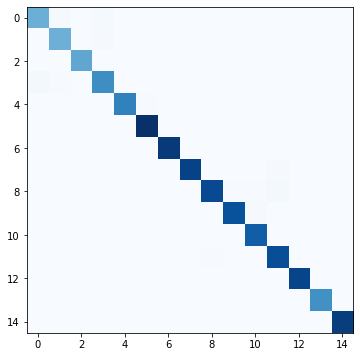

In [120]:
plt.figure(figsize=(6,6))
plt.imshow(confusion_matrix(df['true_label'],df['cla']),cmap=plt.cm.Blues)

In [121]:
print(classification_report(df['true_label'],df['cla']))

                           precision    recall  f1-score   support

  Apple_Alternaria_Boltch       0.95      0.95      0.95       270
          Apple_Grey_spot       0.96      0.97      0.97       260
             Apple_Mosaic       1.00      1.00      1.00       275
               Apple_Rust       0.96      0.95      0.95       344
               Apple_Scab       1.00      0.99      0.99       354
            Apple_healthy       0.99      1.00      1.00       513
      Potato_early_blight       1.00      1.00      1.00       493
       Potato_late_blight       1.00      0.99      0.99       482
      Tomato_Early_blight       0.98      0.97      0.97       478
Tomato_Septoria_leaf_spot       0.98      0.97      0.98       457
    Tomato_bacterial_spot       0.97      1.00      0.99       423
       Tomato_late_blight       0.96      0.98      0.97       461
              Tomato_mold       0.99      0.99      0.99       479
      Tomato_mosaic_virus       0.99      1.00      1.00     

## Class Activate Map

In [236]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [241]:
target_layers = [model.features[-1]]

In [242]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [243]:
targets = [ClassifierOutputTarget(0)]

In [245]:
image=Image.open('./plant_diseases/test/Apple_Alternaria_Boltch/000299.jpg')

In [247]:
test_transform

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [248]:
test_tensor = test_transform(image)

In [249]:
test_tensor.shape

torch.Size([3, 224, 224])

In [250]:
test_tensor = test_tensor.reshape((1,3,224, 224))

In [251]:
grayscale_cam = cam(input_tensor=test_tensor, targets=targets)

In [252]:
grayscale_cam = grayscale_cam[0, :]

In [253]:
grayscale_cam

array([[0.0025669 , 0.0025669 , 0.0025669 , ..., 0.03183857, 0.03183857,
        0.03183857],
       [0.0025669 , 0.0025669 , 0.0025669 , ..., 0.03183857, 0.03183857,
        0.03183857],
       [0.0025669 , 0.0025669 , 0.0025669 , ..., 0.03183857, 0.03183857,
        0.03183857],
       ...,
       [0.00282723, 0.00282723, 0.00282723, ..., 0.        , 0.        ,
        0.        ],
       [0.00282723, 0.00282723, 0.00282723, ..., 0.        , 0.        ,
        0.        ],
       [0.00282723, 0.00282723, 0.00282723, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

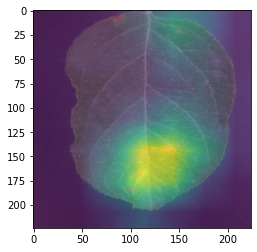

In [264]:
imshow(image.resize((224,224)))
plt.imshow(grayscale_cam,alpha=0.6)